In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import copy
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('..')  # noqa
import abstract_gradient_training as agt
from abstract_gradient_training import AGTConfig
from abstract_gradient_training import model_utils
from abstract_gradient_training import test_metrics
from abstract_gradient_training import privacy_utils

from models.fully_connected import FullyConnected

In [2]:
"""Set up environment, model, data and config for training."""

results_dir = ".results"
notebook_id = "gpt-2-imdb-privacy_results"
seed = 123
batchsize = 20000
torch.manual_seed(seed)
np.random.seed(seed)

# get dataset
X = np.load(".datasets/GPT2_IMDB_X_test.npy")
y = np.load(".datasets/GPT2_IMDB_Y_test.npy")
X_train = np.load(".datasets/GPT2_IMDB_X_train.npy")[10000 - 1 :]
y_train = np.load(".datasets/GPT2_IMDB_Y_train.npy")[10000 - 1 :]
X = np.concatenate((X, X_train), axis=0)
y = np.concatenate((y, y_train), axis=0)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)
train_data = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test))
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batchsize, shuffle=True)

nominal_config = AGTConfig(
    fragsize=5000,
    learning_rate=0.08,
    n_epochs=10,
    device="cuda:0",
    forward_bound="interval",
    backward_bound="interval",
    clip_gamma=0.1,
    early_stopping=False,
    loss="binary_cross_entropy",
    lr_decay=2.0,
    lr_min=0.001,
)
model = FullyConnected(in_dim=768, out_dim=1, hidden_lay=1, hidden_dim=100)
prior_acc = agt.test_metrics.test_accuracy(*model_utils.get_parameters(model), *next(iter(test_loader)))[1]

In [3]:
"""Complete all sweeps"""

def run_with_config(config):
    """If results for this configuration are already computed, load them from disk. Otherwise, run the certified
    training using AGT, then save and return the results."""
    fname = f"{results_dir}/{notebook_id}_{config.hash()}"
    if os.path.isfile(fname):  # run exists, so return the previous results
        param_l, param_n, param_u = torch.load(fname)
    else:
        # check whether the given config should be either unlearning or privacy training
        assert not config.k_unlearn
        np.random.seed(seed)
        torch.manual_seed(seed)
        param_l, param_n, param_u = agt.privacy_certified_training(
            model, config, train_loader, test_loader, transform=model_utils.propagate_conv_layers
        )
        torch.save((param_l, param_n, param_u), fname)
    return param_l, param_n, param_u

conf = copy.deepcopy(nominal_config)
k_private = list(range(0, 101, 1))
privacy_results = {}

for k in k_private:
    print(f"\r{k}", end="")
    conf = copy.deepcopy(nominal_config)
    conf.k_private = k
    conf.log_level = "WARNING" if k > 0 else "DEBUG"
    privacy_results[k] = run_with_config(conf)

[AGT] [INFO    ] [02:21:23] =================== Starting Privacy Certified Training ===================
[AGT] [DEBUG   ] [02:21:23] 	Optimizer params: n_epochs=10, learning_rate=0.08, l1_reg=0.0, l2_reg=0.0
[AGT] [DEBUG   ] [02:21:23] 	Learning rate schedule: lr_decay=2.0, lr_min=0.001, early_stopping=False
[AGT] [DEBUG   ] [02:21:23] 	Privacy parameter: k_private=0
[AGT] [DEBUG   ] [02:21:23] 	Clipping: gamma=0.1, method=clamp
[AGT] [DEBUG   ] [02:21:23] 	Noise: type=gaussian, sigma=0


[AGT] [DEBUG   ] [02:21:23] 	Bounding methods: forward=interval, loss=binary_cross_entropy, backward=interval


0

[AGT] [INFO    ] [02:21:23] Starting epoch 1
[AGT] [DEBUG   ] [02:21:23] Initialising dataloader batchsize to 20000
[AGT] [INFO    ] [02:21:24] Training batch 1: Network eval bounds=(0.51, 0.51, 0.51), W0 Bound=0.0 
[AGT] [DEBUG   ] [02:21:24] Skipping batch 2 in epoch 1 (expected batchsize 20000, got 16000)
[AGT] [INFO    ] [02:21:24] Starting epoch 2
[AGT] [INFO    ] [02:21:25] Training batch 2: Network eval bounds=(0.7 , 0.7 , 0.7 ), W0 Bound=0.0 
[AGT] [DEBUG   ] [02:21:26] Skipping batch 2 in epoch 2 (expected batchsize 20000, got 16000)
[AGT] [INFO    ] [02:21:26] Starting epoch 3
[AGT] [INFO    ] [02:21:26] Training batch 3: Network eval bounds=(0.72, 0.72, 0.72), W0 Bound=0.0 
[AGT] [DEBUG   ] [02:21:26] Skipping batch 2 in epoch 3 (expected batchsize 20000, got 16000)
[AGT] [INFO    ] [02:21:26] Starting epoch 4
[AGT] [INFO    ] [02:21:27] Training batch 4: Network eval bounds=(0.73, 0.73, 0.73), W0 Bound=0.0 
[AGT] [DEBUG   ] [02:21:27] Skipping batch 2 in epoch 4 (expected b

100

In [4]:
"""Reduce noise added using the smooth sensitivity and epsilon-delta privacy for a range of epsilons"""

epsilons = torch.logspace(-2, 1, 40)
test_point, test_label = next(iter(test_loader))
param_n = privacy_results[0][1]
cauchy_means = []
cauchy_stds = []
laplace_means = []
laplace_stds = []

noise_free_acc = test_metrics.test_accuracy(param_n, param_n, param_n, test_point, test_label)[1]

n_runs = 100

for epsilon in epsilons:
    noise_level = privacy_utils.get_calibrated_noise_level(
        test_point,
        test_label,
        privacy_results,
        epsilon,
        noise_type="cauchy",
    )
    private_accs_cauchy = []
    private_accs_laplace = []
    for _ in range(n_runs):
        private_accs_cauchy.append(
            privacy_utils.noisy_test_accuracy(
                param_n,
                test_point,
                test_label,
                noise_level=noise_level,
                noise_type="cauchy",
            )
        )
        private_accs_laplace.append(
            privacy_utils.noisy_test_accuracy(
                param_n,
                test_point,
                test_label,
                noise_level=1 / epsilon,
                noise_type="laplace",
            )
        )
    cauchy_means.append(np.mean(private_accs_cauchy))
    cauchy_stds.append(np.std(private_accs_cauchy))
    laplace_means.append(np.mean(private_accs_laplace))
    laplace_stds.append(np.std(private_accs_laplace))

In [5]:
"""Add constant noise, and compute the local epsilons."""

delta = 10**-5
local_eps = []

for epsilon in epsilons:
    epsilon = float(epsilon)
    local_epsilons = privacy_utils.compute_local_epsilons(test_point, test_label, privacy_results, epsilon, delta)
    local_eps.append(local_epsilons.mean().item())

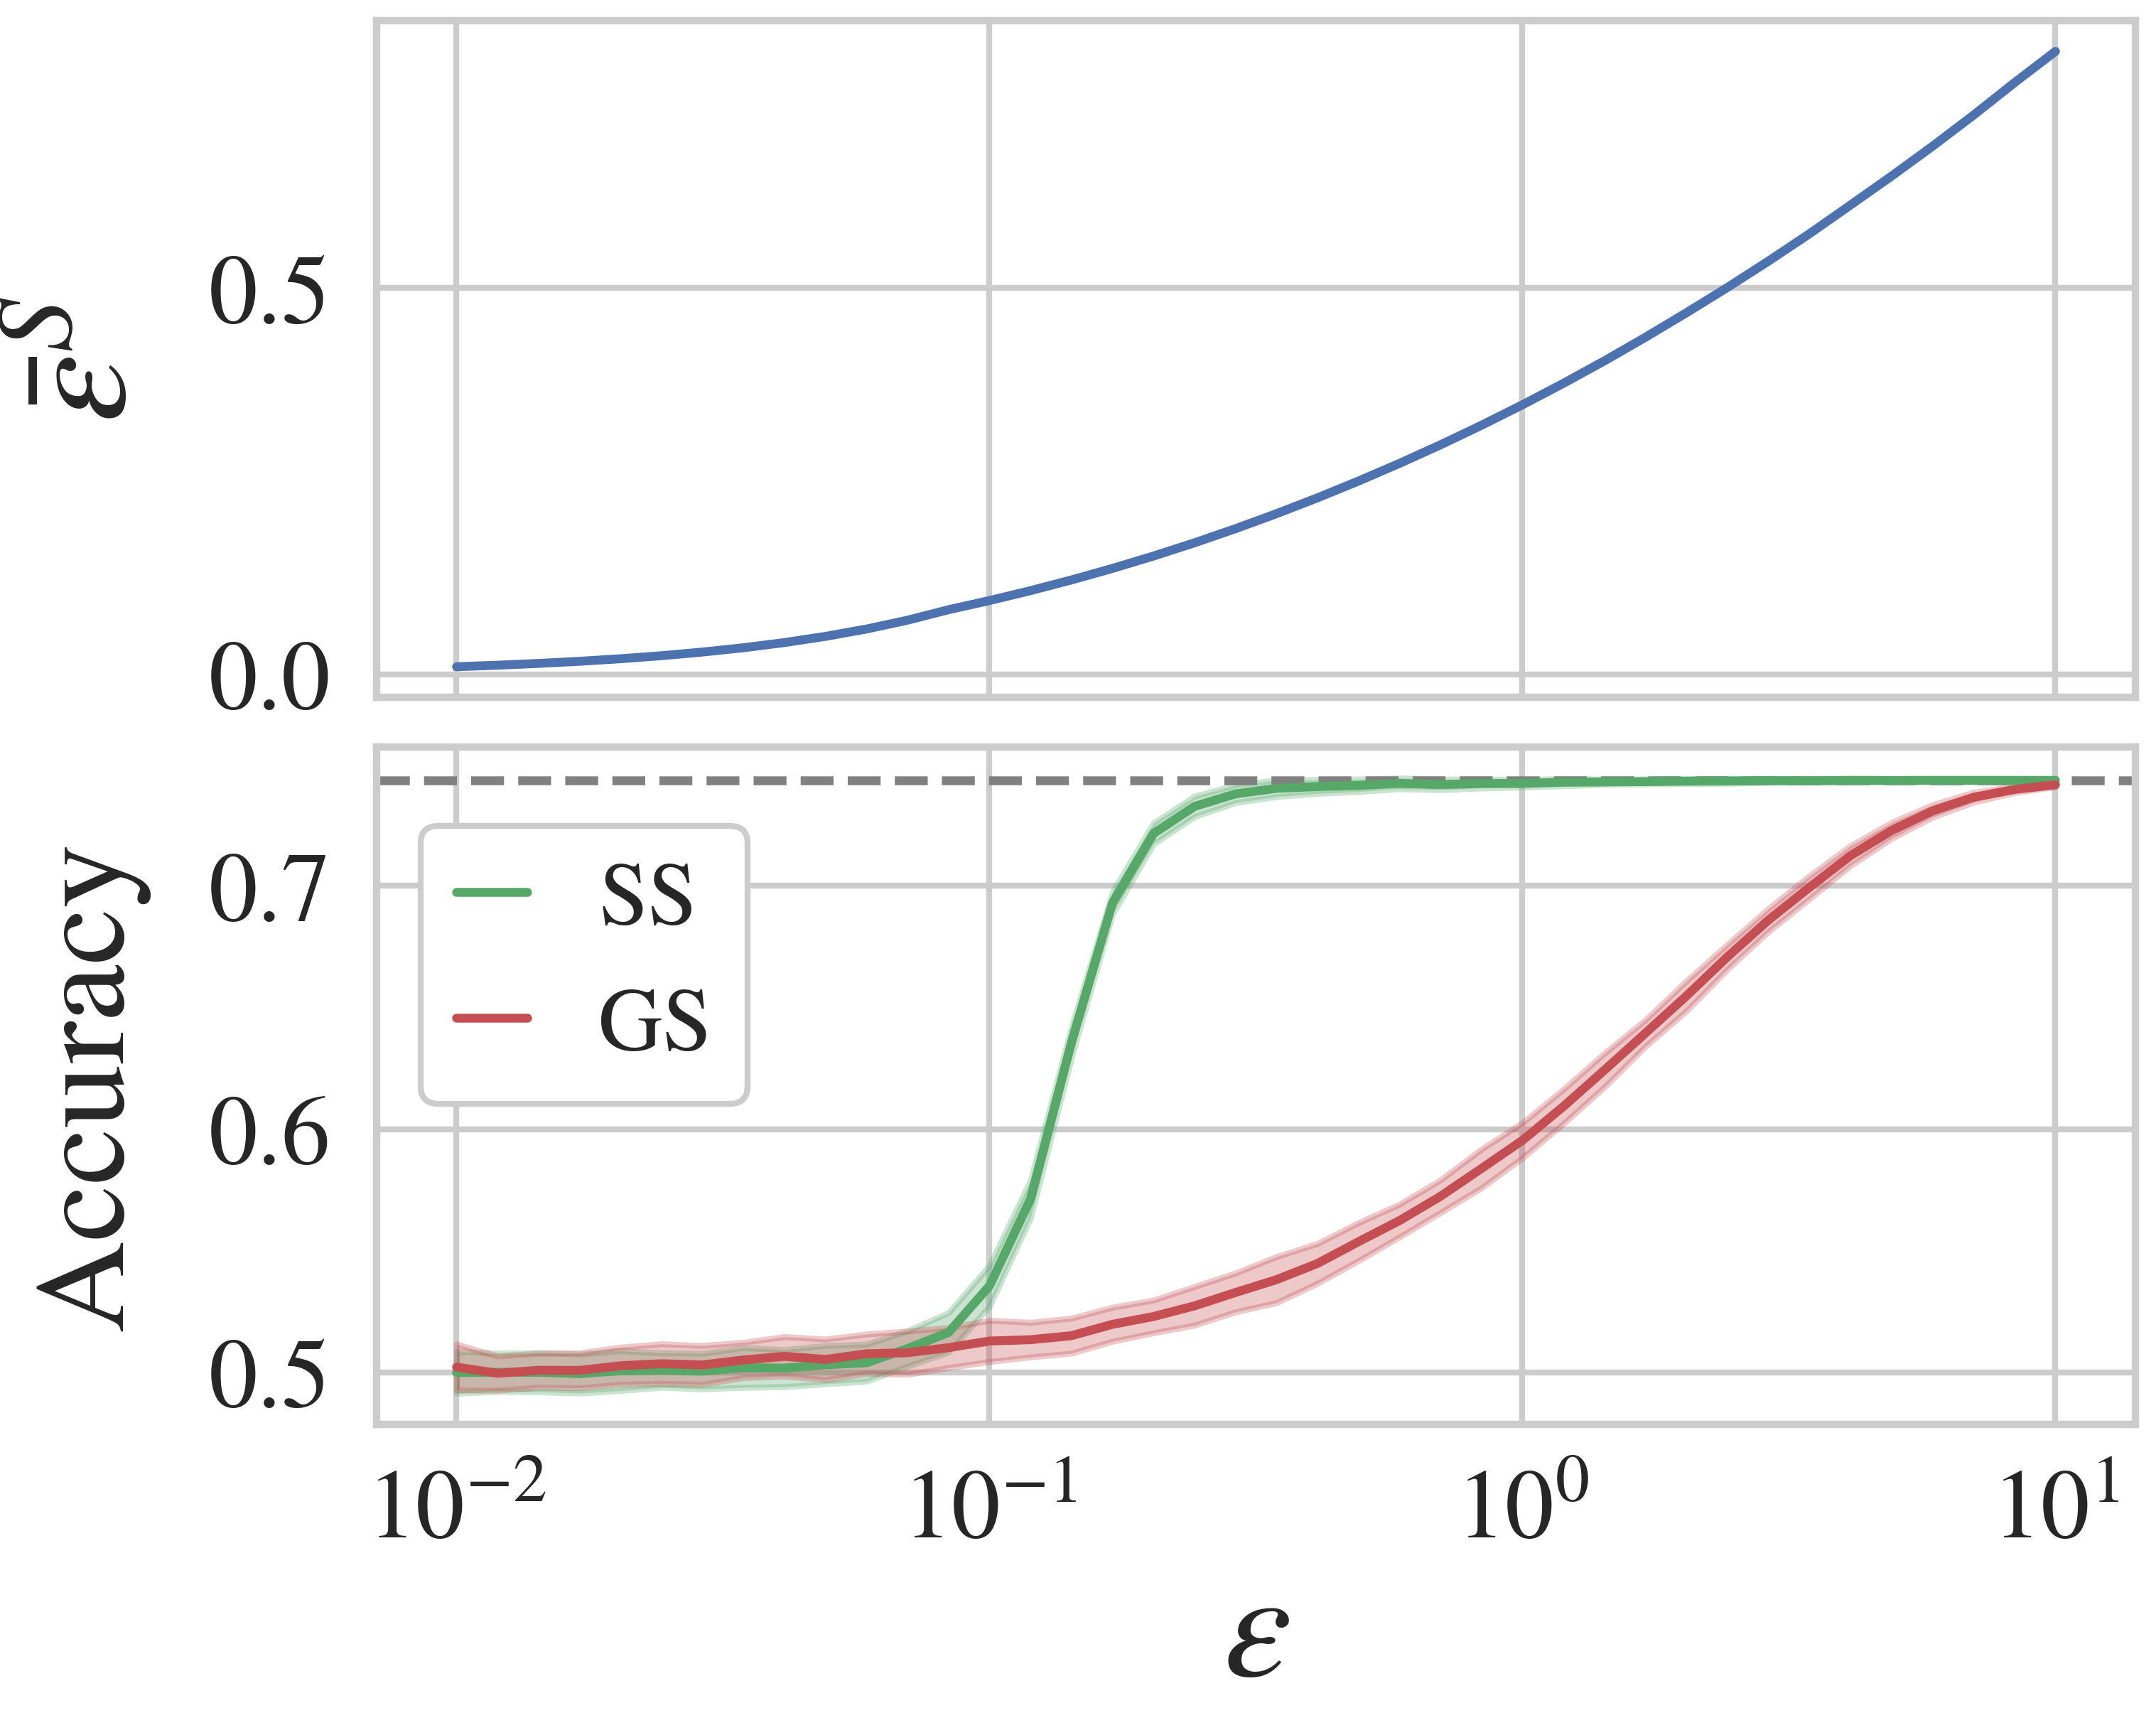

In [6]:
barcolor = sns.color_palette("deep")[0]
laplacecolor = sns.color_palette("deep")[3]
cauchycolor = sns.color_palette("deep")[2]

sns.set_theme(context="poster", style="whitegrid", font_scale=1.5)
mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams["font.family"] = "STIXGeneral"

fig, axs = plt.subplots(2, 1, figsize=(10, 8), layout="constrained", sharex=True, dpi=300)

axs[0].set_xscale("log")
axs[1].set_xlabel("$\epsilon$", fontsize="x-large")

axs[0].plot(epsilons, np.array(local_eps), c=barcolor)

axs[1].set_ylabel("Accuracy", fontsize="large", labelpad=20)
axs[0].set_ylabel(r"${\bar{\epsilon}^S}$", fontsize="x-large", labelpad=40, va="center")

axs[1].axhline(noise_free_acc, c="gray", linestyle="--")
axs[1].plot(epsilons, cauchy_means, c=cauchycolor, label="SS")
axs[1].fill_between(
    epsilons,
    np.array(cauchy_means) - np.array(cauchy_stds),
    np.array(cauchy_means) + np.array(cauchy_stds),
    color=cauchycolor,
    alpha=0.3,
)
axs[1].plot(epsilons, laplace_means, c=laplacecolor, label="GS")
axs[1].fill_between(
    epsilons,
    np.array(laplace_means) - np.array(laplace_stds),
    np.array(laplace_means) + np.array(laplace_stds),
    color=laplacecolor,
    alpha=0.3,
)
axs[1].legend(loc="upper left", handlelength=0.8, framealpha=1.0, bbox_to_anchor=(0.0, 0.95), fontsize="small")
axs[0].yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%0.1f'))
axs[1].yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%0.1f'))
plt.savefig(".figures/gpt_ss_usage.pdf", bbox_inches="tight", dpi=300)